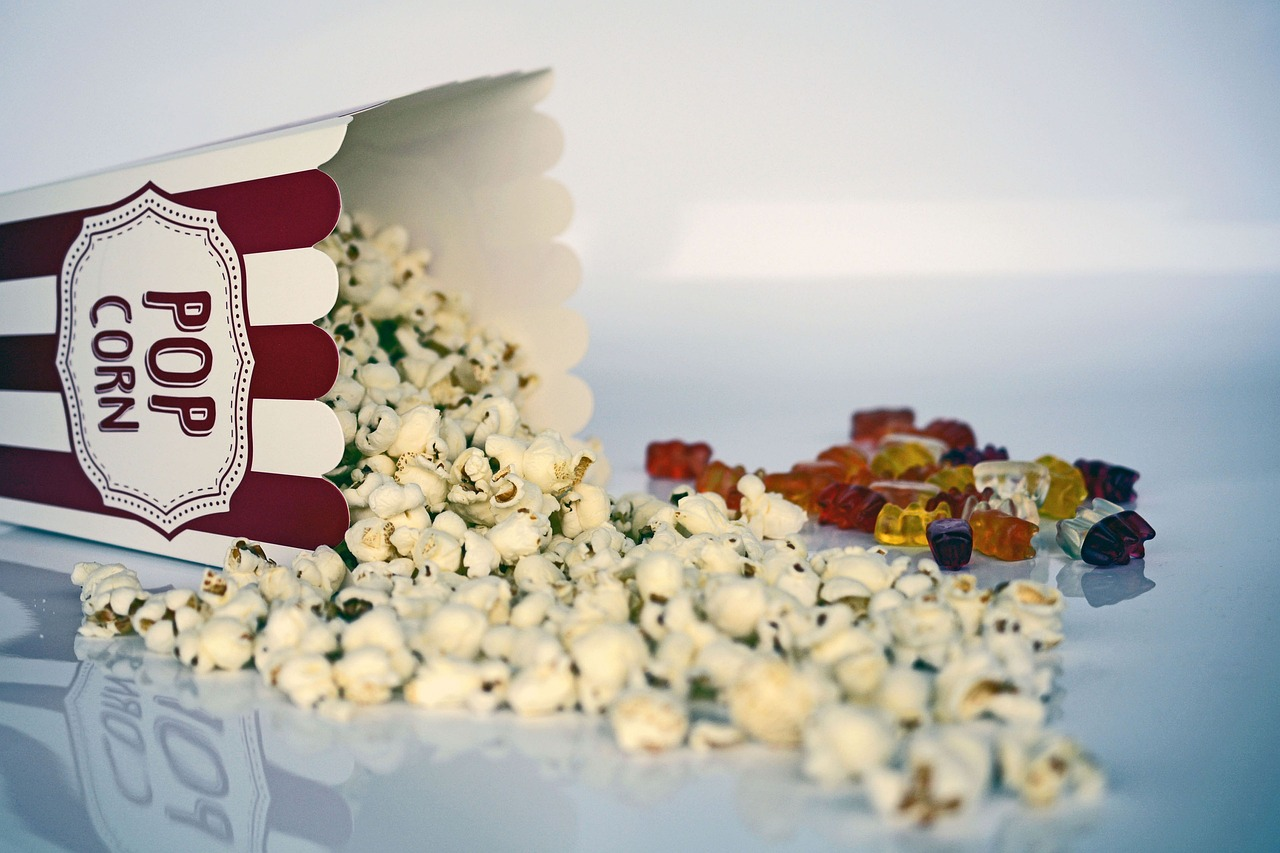

# Background

The following analysis seeks predict IMDB reviews using Natural Language Processing techniques. This analysis will try to predict the IMDB reviews using the naive bayes, logistic regression and the SGD Classifier. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Packages
import pandas as pd
import plotly.express as px
import numpy as np

In [3]:
# Reading in the data
reviews_df = pd.read_csv('/content/drive/MyDrive/imdb_sentiment_analysis/data/IMDB Dataset.csv')
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Size of data
reviews_df.shape

(50000, 2)

In [5]:
# Variable information 
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We will need to convert our target class to numeric as it is of the string class

In [6]:
# Missing values scale
reviews_df.isnull().sum()/ len(reviews_df)

review       0.0
sentiment    0.0
dtype: float64

We do not have any missing data

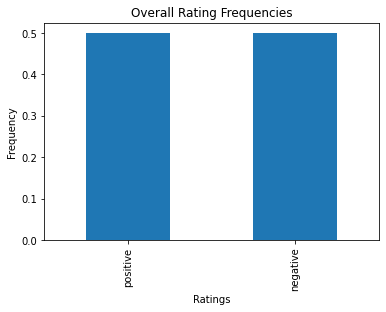

In [7]:
# Overall Rating class 
reviews_df["sentiment"].value_counts(normalize=True).plot(
    kind= 'bar',
    xlabel = "Ratings",
    ylabel = "Frequency",
    title= "Overall Rating Frequencies"
);

There are 2 classes that emanate, which are equally balanced (50% each)

## Feature Engineering

In [8]:
# Define a function to engineer the variables
def wrangle(df):

    # New rating variable
    df["rating"] = np.where(df["sentiment"] == "positive", 1, 0)

    # Drop the old rating
    df = df.drop(columns = ["sentiment"])

    # Get the final data
    return df

In [9]:
# Get the new features
final_df = wrangle(reviews_df)
final_df.head()

,review,rating
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Modelling

The following are the packages that we will use

In [10]:
# Packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from time import time
import logging



In [11]:
# Splitting the data
X = final_df.review 
y = final_df.rating

X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size= 0.25, random_state=42
)


In [12]:
# The size of the sets
print("The X train set size is: ", X_train.shape)
print('The X test set size is:', X_test.shape)
print('The y train set size is:', y_train.shape)
print('The y test set size is:', y_test.shape)

The X train set size is:  (37500,)
The X test set size is: (12500,)
The y train set size is: (37500,)
The y test set size is: (12500,)


In [13]:
# The train set
X_train.head()

27434    I figure this to be an "alternate reality" tee...
13400    This is the kind of movie that wants to be goo...
883      This was by far the worst movie I've ever seen...
7303     Awful, awful, awful...<br /><br />I loved the ...
45124    Fragile Carne, just before his great period. A...
Name: review, dtype: object

In [14]:
# Removing stop words and 1-gram
vectorizer = CountVectorizer(
    strip_accents= "ascii",
    stop_words= "english",
    lowercase= False, 
    ngram_range=(1,1)
)

X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)



## Naive Bayes Model

In [15]:
# Multinomial Naive Bayes model
clf_nb = MultinomialNB()
start_time = time()
clf_nb.fit(X_train_bow, y_train)
print("done in %0.3fs" % (time() - start_time))
accuracy_nb = clf_nb.score(X_test_bow, y_test)
print("The accuracy of the model is :", accuracy_nb)

done in 0.049s
The accuracy of the model is : 0.8576


## Logistic Regression

In [16]:
# Logistic Regrission model
clf_log = LogisticRegression(max_iter=1000)
start_time = time()
clf_log.fit(X_train_bow, y_train)
print("done in %0.3fs" % (time() - start_time))
accuracy_log = clf_log.score(X_test_bow, y_test)
print("The accuracy of the model is :", accuracy_log)

done in 42.106s
The accuracy of the model is : 0.88448


## SGD Classifier

In [17]:
# SGD Classifier model
clf_sgd = SGDClassifier()
start_time = time()
clf_sgd.fit(X_train_bow, y_train)
print("done in %0.3fs" % (time() - start_time))
accuracy_sgd = clf_sgd.score(X_test_bow, y_test)
print("The accuracy of the model is :", accuracy_sgd)

done in 1.366s
The accuracy of the model is : 0.87632


## Hyperparameter Tuning

Since the Naive Bayes model has the lowest computational cost and good acurracy score we will use it for this analysis looking at the following:
1. usage of 1 or the 2 n-grams, 
2. using or not using stop words 

Investigating other parameters increases the complexity and the computational time. Hence, only these  parameters/issues are investigated

### Multinomial Naive Bayes Hyper parameter tuning

In [18]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", MultinomialNB())
    ]
)


# Parameters to use for grid search. Uncommenting more parameters will give
# better exploring power but will increase processing time in a combinatorial
# way
parameters = {
    "vect__stop_words": (None, "english"),
    "vect__strip_accents": (None, "ascii"),
    "vect__ngram_range": ((1, 1), (1, 2))#,  # unigrams or bigrams
}

# Find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, 
    parameters, 
    n_jobs=-1, 
    verbose=1)

start_time = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - start_time))

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
done in 640.683s
Best score: 0.880
Best parameters set:
	vect__ngram_range: (1, 2)
	vect__stop_words: None
	vect__strip_accents: None


The best model performs better with no stop words, 2 n-grams and no accents achieving an accuracy of 0.88. It is yet to be established, that is the increase in accuracy worth the computational power.

## Conclusion

Judging from the computation power and performance, perhaps the neural networks can perform better than these surveyed models
